DATASET DE 9GB PRIMERO

In [ ]:
# PASO 1.1 — Montar Drive y LISTAR .zip
from google.colab import drive
drive.mount('/content/drive')

import os, glob

# Ajusta si usas otra carpeta
CANDIDATE_DIRS = [
    "/content/drive/MyDrive/DATASETS/dataset_1024_resolucion",
    "/content/drive/MyDrive/Colab Notebooks/DATASETS/dataset_1024_resolucion",
]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = None
for d in CANDIDATE_DIRS:
    if os.path.isdir(d):
        BASE_DIR = d
        break

if BASE_DIR is None:
    print("❌ No encontré la carpeta del dataset en las rutas esperadas.")
    print("Indícame la ruta exacta. Contenido de /content/drive/MyDrive:")
    for item in sorted(os.listdir("/content/drive/MyDrive")):
        print(" -", item)
else:
    print("✅ Carpeta localizada en:", BASE_DIR)
    zips = sorted(glob.glob(os.path.join(BASE_DIR, "*.zip")))
    if not zips:
        print("❌ No hay .zip en esa carpeta.")
    else:
        print("ZIPs encontrados:")
        for z in zips:
            print(" -", os.path.basename(z))
        v1 = [z for z in zips if "v1" in os.path.basename(z).lower()]
        SELECTED_ZIP = v1[0] if v1 else zips[0]
        print("\n➡️  Seleccionado para el PASO 1.2:", os.path.basename(SELECTED_ZIP))

✅ Carpeta localizada en: /content/drive/MyDrive/Colab Notebooks/DATASETS/dataset_1024_resolucion
ZIPs encontrados:
 - dataset_arboles_v3.zip
 - dataset_arboles_v4.zip

➡️  Seleccionado para el PASO 1.2: dataset_arboles_v3.zip


In [ ]:
# PASO 1.2 — Copiar y descomprimir el ZIP v1 en /content
import os, shutil, zipfile

# Usa la misma variable BASE_DIR del paso anterior
ZIP_V1 = None
for f in os.listdir(BASE_DIR):
    if "v3" in f.lower() and f.endswith(".zip"):
        ZIP_V1 = os.path.join(BASE_DIR, f)
        break

if ZIP_V1 is None:
    raise FileNotFoundError("No encontré un archivo con 'v1' en su nombre dentro de la carpeta del dataset.")

print("📦 Archivo v1 seleccionado:", os.path.basename(ZIP_V1))

📦 Archivo v1 seleccionado: dataset_arboles_v3.zip


In [ ]:
# Copiar al almacenamiento local de Colab (más rápido)
local_zip = "/content/dataset_v3.zip"
if os.path.exists(local_zip):
    os.remove(local_zip)
shutil.copy2(ZIP_V1, local_zip)
print("✅ Copiado a:", local_zip)

✅ Copiado a: /content/dataset_v3.zip


In [ ]:
# Descomprimir en carpeta limpia
extract_dir = "/content/dataset_yolov3_m"
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(local_zip, "r") as zf:
    zf.extractall(extract_dir)

print("✅ Descomprimido en:", extract_dir)
print("\nContenido de primer nivel:")
for item in os.listdir(extract_dir):
    p = os.path.join(extract_dir, item)
    print(" - [DIR]" if os.path.isdir(p) else " - [FILE]", item)

✅ Descomprimido en: /content/dataset_yolov3_m

Contenido de primer nivel:
 - [DIR] dataset_arboles_v3


In [ ]:
# PASO 2.1 — Detectar la carpeta raíz del dataset descomprimido
import os

EXTRACT_DIR = "/content/dataset_yolov3_m"  # carpeta donde se descomprimió el ZIP

def pick_root(extract_dir):
    """Si solo hay una subcarpeta dentro, entrar en ella; si no, usar extract_dir."""
    items = [i for i in os.listdir(extract_dir) if not i.startswith(".")]
    if len(items) == 1 and os.path.isdir(os.path.join(extract_dir, items[0])):
        return os.path.join(extract_dir, items[0])
    return extract_dir

ROOT = pick_root(EXTRACT_DIR)

print("📁 Raíz detectada:", ROOT)
print("\nContenido dentro de la raíz:")
for i in os.listdir(ROOT):
    print(" -", i)


📁 Raíz detectada: /content/dataset_yolov3_m/dataset_arboles_v3

Contenido dentro de la raíz:
 - data.yaml
 - images
 - labels


In [ ]:
# PASO 2.2 — Buscar y leer data.yaml (si existe)
import os, glob, yaml

yaml_candidates = []
for pattern in ("*.yaml", "*.yml"):
    yaml_candidates += glob.glob(os.path.join(ROOT, pattern))

if not yaml_candidates:
    print("❌ No se encontró data.yaml ni data.yml en la raíz del dataset.")
else:
    print("✅ Archivos YAML encontrados:")
    for y in yaml_candidates:
        print(" -", os.path.basename(y))

    try:
        # Tomar preferentemente el que se llame data.yaml
        preferred = [y for y in yaml_candidates if "data" in os.path.basename(y).lower()]
        preferred = preferred[0] if preferred else yaml_candidates[0]
        print("\n📄 Leyendo:", os.path.basename(preferred))

        with open(preferred, "r", encoding="utf-8") as f:
            yaml_info = yaml.safe_load(f)

        print("\nContenido del YAML:\n")
        print(yaml_info)
    except Exception as e:
        print("⚠ Error al leer el YAML:", e)

✅ Archivos YAML encontrados:
 - data.yaml

📄 Leyendo: data.yaml

Contenido del YAML:

{'path': '/content/drive/MyDrive/Colab Notebooks/DATASETS/dataset_1024_resolucion/', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'names': {0: 'arbol'}}


In [ ]:
# PASO 2.3 — Detectar estructura YOLO (images/labels por split)
import os

splits = ["train", "val", "test"]
layout = None
paths = {}

# Caso A: images/train y labels/train
if os.path.isdir(os.path.join(ROOT, "images")) and os.path.isdir(os.path.join(ROOT, "labels")):
    layout = "images_split"
    for s in splits:
        paths[s] = {
            "images": os.path.join(ROOT, "images", s),
            "labels": os.path.join(ROOT, "labels", s)
        }

# Caso B: train/images y val/images
if layout is None:
    ok = True
    temp = {}
    for s in splits:
        si = os.path.join(ROOT, s, "images")
        sl = os.path.join(ROOT, s, "labels")
        if not (os.path.isdir(si) and os.path.isdir(sl)):
            ok = False
            break
        temp[s] = {"images": si, "labels": sl}
    if ok:
        layout = "split_images"
        paths = temp

if layout:
    print("✅ Estructura detectada:", layout)
    for s, d in paths.items():
        print(f"\n{s.upper()}:")
        print("  images →", d["images"])
        print("  labels →", d["labels"])
else:
    print("❌ No se detectó estructura YOLO válida.")


✅ Estructura detectada: images_split

TRAIN:
  images → /content/dataset_yolov3_m/dataset_arboles_v3/images/train
  labels → /content/dataset_yolov3_m/dataset_arboles_v3/labels/train

VAL:
  images → /content/dataset_yolov3_m/dataset_arboles_v3/images/val
  labels → /content/dataset_yolov3_m/dataset_arboles_v3/labels/val

TEST:
  images → /content/dataset_yolov3_m/dataset_arboles_v3/images/test
  labels → /content/dataset_yolov3_m/dataset_arboles_v3/labels/test


In [ ]:
# PASO 2.4 — Conteo de imágenes y etiquetas por split
import os

def count_files(img_dir, lbl_dir):
    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    lbls = [f for f in os.listdir(lbl_dir) if f.lower().endswith('.txt')]
    print(f"  🖼️  Imágenes: {len(imgs)}  |  🏷️  Etiquetas: {len(lbls)}")
    if len(imgs) != len(lbls):
        print("  ⚠️  Diferencia detectada entre número de imágenes y etiquetas.")
        # Mostrar ejemplos de archivos sin pareja
        stem_imgs = {os.path.splitext(f)[0] for f in imgs}
        stem_lbls = {os.path.splitext(f)[0] for f in lbls}
        solo_imgs = sorted(list(stem_imgs - stem_lbls))[:5]
        solo_lbls = sorted(list(stem_lbls - stem_imgs))[:5]
        if solo_imgs:
            print("   - Faltan etiquetas para:", solo_imgs)
        if solo_lbls:
            print("   - Faltan imágenes para:", solo_lbls)
    return len(imgs), len(lbls)

if 'paths' in globals() and paths:
    print("\n=== 📊 RESUMEN POR SPLIT ===")
    for s, d in paths.items():
        print(f"\n[{s.upper()}]")
        if os.path.isdir(d["images"]) and os.path.isdir(d["labels"]):
            count_files(d["images"], d["labels"])
        else:
            print("  ❌ Falta carpeta:", d)
else:
    print("❌ No se detectaron rutas válidas en el paso anterior (2.3).")


=== 📊 RESUMEN POR SPLIT ===

[TRAIN]
  🖼️  Imágenes: 5694  |  🏷️  Etiquetas: 5694

[VAL]
  🖼️  Imágenes: 1627  |  🏷️  Etiquetas: 1627

[TEST]
  🖼️  Imágenes: 814  |  🏷️  Etiquetas: 814


In [ ]:
# PASO 3.1 — Instalar y verificar YOLOv8 (Ultralytics)
!pip install ultralytics --upgrade --quiet

from ultralytics import YOLO
import ultralytics

print("✅ Ultralytics instalado correctamente.")
print("Versión:", ultralytics.__version__)

# Verificar GPU disponible
import torch
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ No hay GPU activa")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics instalado correctamente.
Versión: 8.3.221
GPU detectada: NVIDIA A100-SXM4-40GB


In [ ]:
# PASO 3.2 — Crear / Ajustar archivo data.yaml
import os, yaml

yaml_path = os.path.join(ROOT, "data.yaml")

# Rutas relativas desde la raíz del dataset
train_path = os.path.relpath(paths["train"]["images"], ROOT)
val_path   = os.path.relpath(paths["val"]["images"], ROOT)
test_path  = os.path.relpath(paths["test"]["images"], ROOT)

# Definir las clases (ajusta si tienes más de una)
data_config = {
    "path": ROOT,
    "train": train_path,
    "val": val_path,
    "test": test_path,
    "names": ["arbol"],  # puedes añadir más clases aquí
}

with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(data_config, f, sort_keys=False, allow_unicode=True)

print("✅ Archivo data.yaml creado correctamente en:", yaml_path)
print("\nContenido del data.yaml:\n")
print(yaml.dump(data_config, sort_keys=False, allow_unicode=True))


✅ Archivo data.yaml creado correctamente en: /content/dataset_yolov3_m/dataset_arboles_v3/data.yaml

Contenido del data.yaml:

path: /content/dataset_yolov3_m/dataset_arboles_v3
train: images/train
val: images/val
test: images/test
names:
- arbol



In [ ]:
# 🔹 Entrenamiento YOLOv8m - Dataset 1024x1024
from ultralytics import YOLO
import os

# Ruta del YAML de tu dataset
yaml_path = os.path.join(ROOT, "data.yaml")

# Crea el modelo (YOLOv8m = versión mediana, mejor precisión que "s")
model = YOLO("yolov8m.pt")

# Entrenamiento
results = model.train(
    data=yaml_path,
    epochs=100,            # puedes subir a 150 si no hay EarlyStopping
    imgsz=1024,            # resolución alta = mejor precisión
    batch=8,               # ajusta según tu GPU (A100: ok hasta 8)
    device=0,              # usar GPU
    workers=4,
    seed=42,
    project="/content/runs",
    name="yolov8m_1024_precision",

    # Estabilidad y rendimiento
    cos_lr=True,           # scheduler tipo coseno
    patience=50,           # early stop si no mejora
    cache=True,            # cachea las imágenes para acelerar
    close_mosaic=10,       # cierra mosaic en las últimas 10 épocas

    # Guardado y visualización
    save=True,
    save_period=10,        # checkpoint cada 10 épocas
    plots=True,            # genera PR, F1, confusión, etc.
    val=True               # valida cada epoch
)

print("\n✅ Entrenamiento lanzado/finalizado.")
print("📁 Carpeta de resultados:", results.save_dir)
print("🏆 Pesos mejores (best.pt):", os.path.join(str(results.save_dir), "weights", "best.pt"))
print("🕒 Últimos pesos (last.pt):", os.path.join(str(results.save_dir), "weights", "last.pt"))


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_yolov3_m/dataset_arboles_v3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_1024_precision4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

In [ ]:
!ls -lt /content/runs



total 16
drwxr-xr-x 3 root root 4096 Oct 25 03:09 yolov8m_1024_precision4
drwxr-xr-x 3 root root 4096 Oct 24 23:57 yolov8m_1024_precision3
drwxr-xr-x 3 root root 4096 Oct 24 23:56 yolov8m_1024_precision2
drwxr-xr-x 3 root root 4096 Oct 24 23:55 yolov8m_1024_precision


In [ ]:
!cp -r /content/runs/yolov8m_1024_precision4 /content/drive/MyDrive/yolo_runs_backup2/


In [ ]:
from IPython.display import Image, display
import pandas as pd
import os

# Ruta a tu copia en Drive
run_path = "/content/drive/MyDrive/yolo_runs_backup2"

csv_path = f"{run_path}/results.csv"
df = pd.read_csv(csv_path)

print("Columnas disponibles:", df.columns.tolist(), "\n")
print("Últimas métricas del entrenamiento:")
print(df.tail(3))  # últimas 3 filas (finales del entrenamiento)

Columnas disponibles: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'] 

Últimas métricas del entrenamiento:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
97     98  11151.6         1.36662         0.79939         1.38335   
98     99  11264.3         1.36824         0.80696         1.38337   
99    100  11377.1         1.37433         0.81006         1.38833   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
97               0.65905            0.61864           0.64186   
98               0.66423            0.61538           0.64227   
99               0.66792            0.61151           0.64267   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
97              0.30733       1.91671       1.20713       1.87125  0.000024   
98

In [ ]:
precision_final = df["metrics/precision(B)"].iloc[-1]
recall_final = df["metrics/recall(B)"].iloc[-1]
map50_final = df["metrics/mAP50(B)"].iloc[-1]
map95_final = df["metrics/mAP50-95(B)"].iloc[-1]

print(f"Precisión final: {precision_final:.3f}")
print(f"Recall final: {recall_final:.3f}")
print(f"mAP@50: {map50_final:.3f}")
print(f"mAP@50-95: {map95_final:.3f}")


Precisión final: 0.668
Recall final: 0.612
mAP@50: 0.643
mAP@50-95: 0.308


In [ ]:
from ultralytics import YOLO

# Ruta al modelo que entrenaste
BEST_PT = "/content/runs/yolov8m_1024_precision4/weights/best.pt"

# Cargar el modelo
model = YOLO(BEST_PT)
print("✅ Modelo cargado correctamente:", BEST_PT)


✅ Modelo cargado correctamente: /content/runs/yolov8m_1024_precision4/weights/best.pt


Results saved to /content/runs/detect/predict


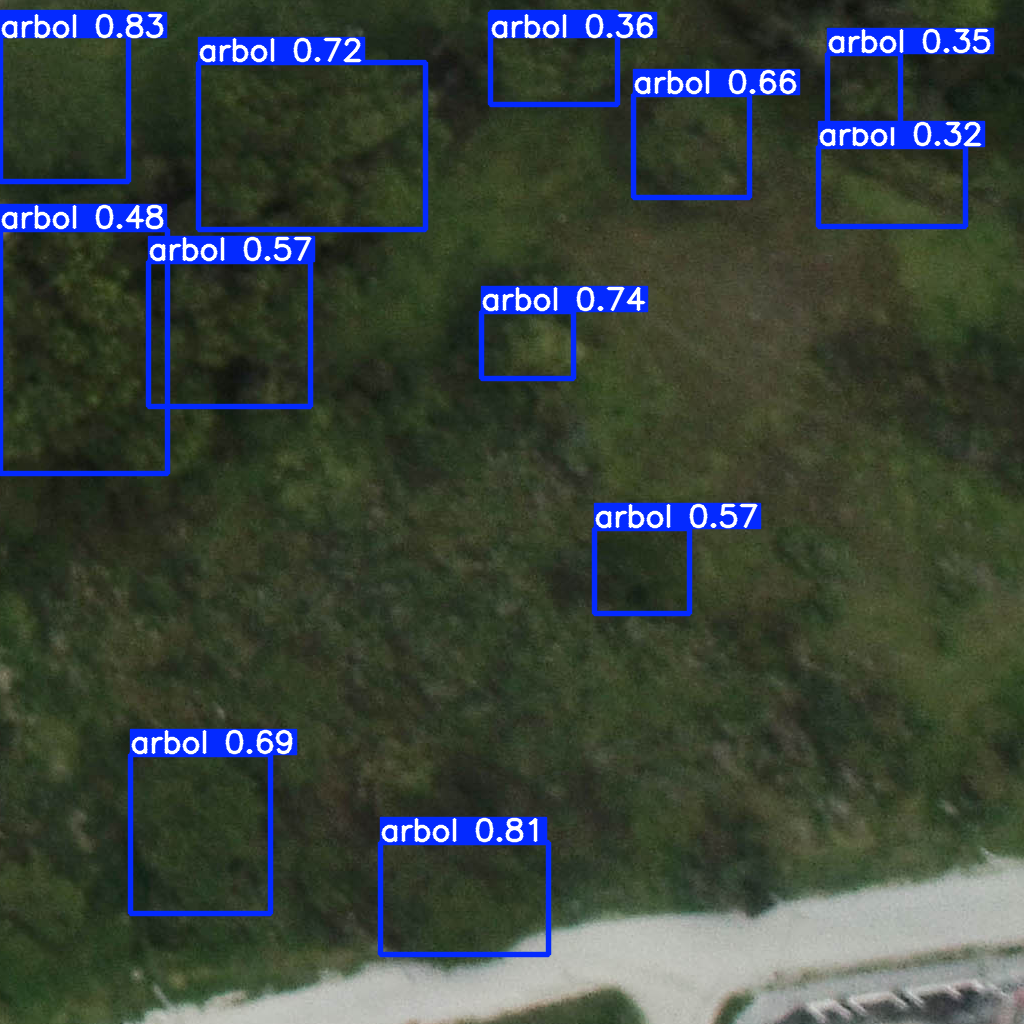

🌿 Árboles detectados: 12
📁 Imagen anotada guardada en: /content/runs/detect/predict


In [ ]:
from PIL import Image
from IPython.display import display

# Ruta de una imagen de prueba (puedes cambiarla)
IMG_PATH = "/content/dataset_yolov3_m/dataset_arboles_v3/images/val/DJI_IMG_0068_03_05.png"

# Inferencia
results = model.predict(
    source=IMG_PATH,
    imgsz=1024,     # o 1024 si tu dataset fue 1024x1024
    conf=0.25,     # umbral de confianza
    iou=0.45,      # supresión no máxima
    save=True,     # guarda la imagen anotada
    verbose=False
)

# Mostrar imagen anotada
r = results[0]
annotated = r.plot()[:, :, ::-1]  # BGR -> RGB
display(Image.fromarray(annotated))

# Conteo de detecciones
num_det = len(r.boxes) if r.boxes is not None else 0
print(f"🌿 Árboles detectados: {num_det}")

# Carpeta donde se guardó la imagen resultante
print("📁 Imagen anotada guardada en:", r.save_dir)


Results saved to /content/runs/detect/predict


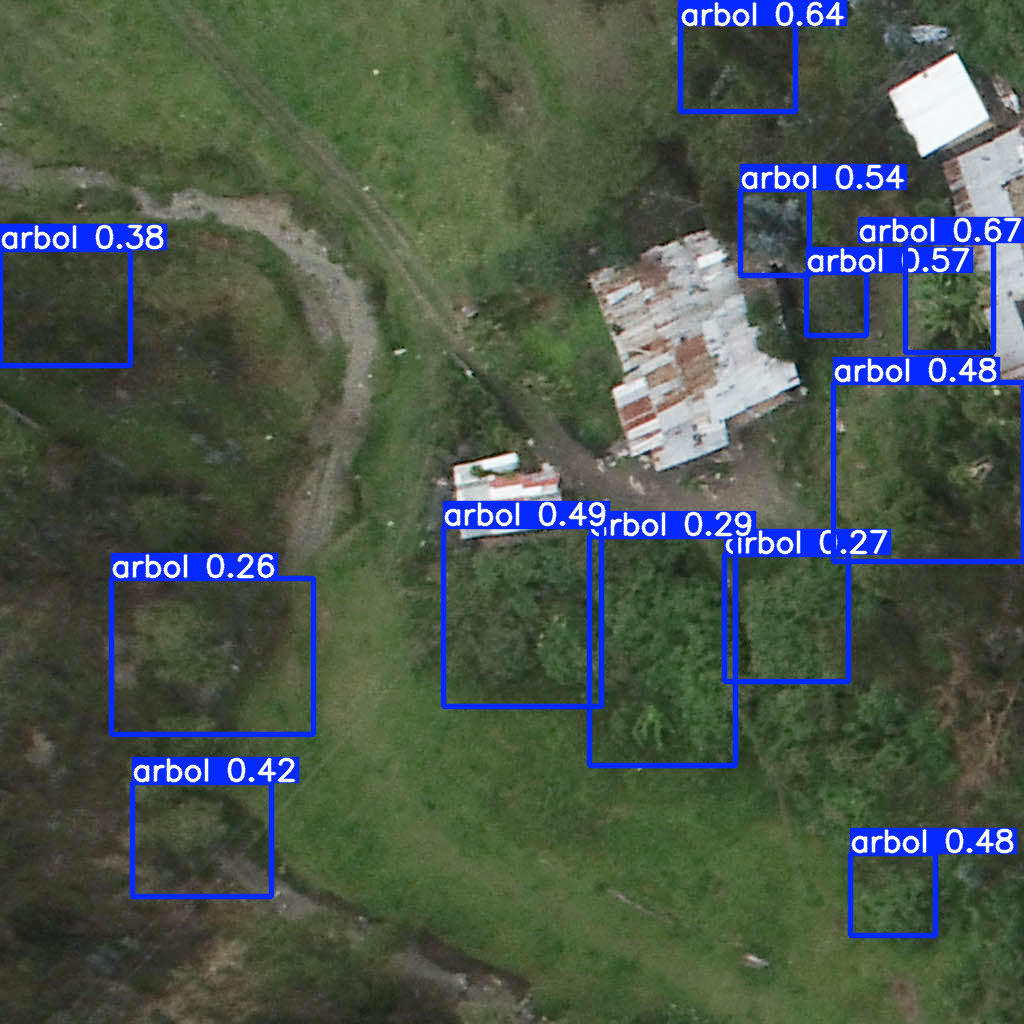

🌿 Árboles detectados: 12
📁 Imagen anotada guardada en: /content/runs/detect/predict


In [ ]:
from PIL import Image
from IPython.display import display

# Ruta de una imagen de prueba (puedes cambiarla)
IMG_PATH = "/content/dataset_yolov3_m/dataset_arboles_v3/images/val/DJI_IMG_0185_00_00.png"

# Inferencia
results = model.predict(
    source=IMG_PATH,
    imgsz=1024,     # o 1024 si tu dataset fue 1024x1024
    conf=0.25,     # umbral de confianza
    iou=0.45,      # supresión no máxima
    save=True,     # guarda la imagen anotada
    verbose=False
)

# Mostrar imagen anotada
r = results[0]
annotated = r.plot()[:, :, ::-1]  # BGR -> RGB
display(Image.fromarray(annotated))

# Conteo de detecciones
num_det = len(r.boxes) if r.boxes is not None else 0
print(f"🌿 Árboles detectados: {num_det}")

# Carpeta donde se guardó la imagen resultante
print("📁 Imagen anotada guardada en:", r.save_dir)

Results saved to /content/runs/detect/predict


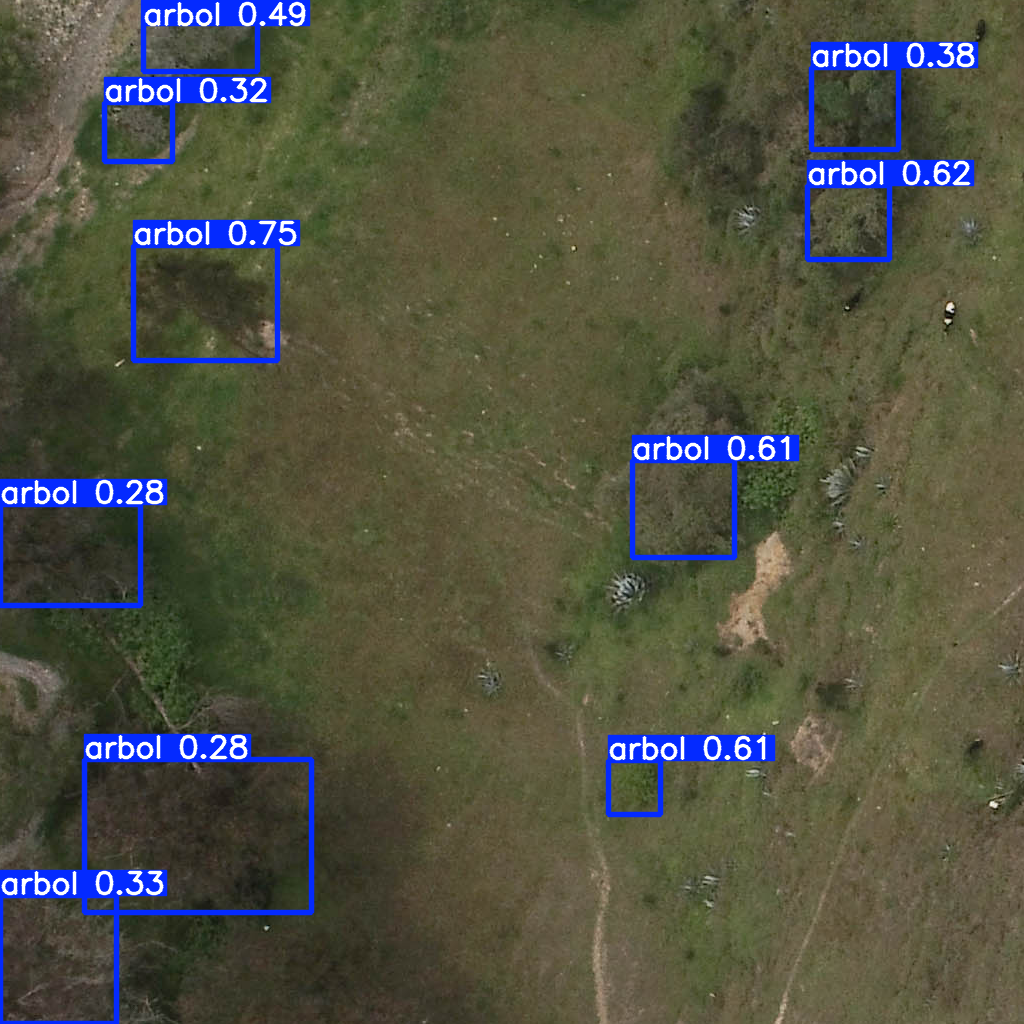

🌿 Árboles detectados: 10
📁 Imagen anotada guardada en: /content/runs/detect/predict


In [ ]:
from PIL import Image
from IPython.display import display

# Ruta de una imagen de prueba (puedes cambiarla)
IMG_PATH = "/content/dataset_yolov3_m/dataset_arboles_v3/images/val/DJI_IMG_0318_01_02.png"

# Inferencia
results = model.predict(
    source=IMG_PATH,
    imgsz=1024,     # o 1024 si tu dataset fue 1024x1024
    conf=0.25,     # umbral de confianza
    iou=0.45,      # supresión no máxima
    save=True,     # guarda la imagen anotada
    verbose=False
)

# Mostrar imagen anotada
r = results[0]
annotated = r.plot()[:, :, ::-1]  # BGR -> RGB
display(Image.fromarray(annotated))

# Conteo de detecciones
num_det = len(r.boxes) if r.boxes is not None else 0
print(f"🌿 Árboles detectados: {num_det}")

# Carpeta donde se guardó la imagen resultante
print("📁 Imagen anotada guardada en:", r.save_dir)

FINNE TUNING PROBAR MODELO CON ESO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/


'Colab Notebooks'   Mantenimiento_Equipos_2025_firmado.rar   yolov8_runs_backup
 DATASET_PIC	   'TIC DOCUMENTO'
 DOCUMENTO_IEES     yolo_runs_backup2


In [ ]:
BEST_PATH = "/content/drive/MyDrive/yolo_runs_backup2/weights/best.pt"


In [ ]:
!ls "$BEST_PATH"


/content/drive/MyDrive/yolo_runs_backup2/weights/best.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 🔧 RUTAS QUE DEBES EDITAR SEGÚN TU DRIVE
ZIP_PATH     = "/content/drive/MyDrive/Colab Notebooks/DATASETS/dataset_1024_resolucion/dataset_arboles_v3.zip"   # <-- pon aquí tu .zip en Drive
EXTRACT_DIR  = "/content/dataset_yolov1_1024_finetune"              # carpeta destino en /content
# Si quieres, cambia el nombre del experimento:
RUN_NAME     = "yolov8m_finetuned_1024"

# ⚠️ IMPORTANTE: ruta al best.pt que YA guardaste en tu Drive
BEST_PATH    = "/content/drive/MyDrive/yolo_runs_backup2/weights/best.pt"  # <-- edita


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, shutil, zipfile

# Limpieza previa del destino
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Copiar ZIP desde Drive a /content (más rápido para lectura)
local_zip = "/content/dataset_finetune.zip"
if os.path.exists(local_zip):
    os.remove(local_zip)
shutil.copy2(ZIP_PATH, local_zip)
print("✅ Copiado ZIP a:", local_zip)

# Descomprimir
with zipfile.ZipFile(local_zip, "r") as zf:
    zf.extractall(EXTRACT_DIR)

print("✅ Descomprimido en:", EXTRACT_DIR)
print("\n📁 Contenido de primer nivel:")
for item in os.listdir(EXTRACT_DIR):
    p = os.path.join(EXTRACT_DIR, item)
    print(" - [DIR]" if os.path.isdir(p) else " - [FILE]", item)


✅ Copiado ZIP a: /content/dataset_finetune.zip
✅ Descomprimido en: /content/dataset_yolov1_1024_finetune

📁 Contenido de primer nivel:
 - [DIR] dataset_arboles_v3


In [ ]:
import os, yaml

# Ruta correcta a la carpeta descomprimida en /content
ROOT = "/content/dataset_yolov1_1024_finetune/dataset_arboles_v3"
yaml_path = os.path.join(ROOT, "data.yaml")

# Reescribir YAML para que apunte a /content y normalizar 'names' como lista
new_yaml = {
    "path": ROOT,
test: images/test
names:
  0: arbol

    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "names": ["arbol"]
}

with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(new_yaml, f, sort_keys=False, allow_unicode=True)

print("✅ YAML reescrito en:", yaml_path)
print(new_yaml)

# Verificación
for split in ["train", "val", "test"]:
    p = os.path.join(ROOT, "images", split)
    print(f"🔹 {split}: {os.path.exists(p)}  ({p})")


✅ YAML reescrito en: /content/dataset_yolov1_1024_finetune/dataset_arboles_v3/data.yaml
{'path': '/content/dataset_yolov1_1024_finetune/dataset_arboles_v3', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'names': ['arbol']}
🔹 train: True  (/content/dataset_yolov1_1024_finetune/dataset_arboles_v3/images/train)
🔹 val: True  (/content/dataset_yolov1_1024_finetune/dataset_arboles_v3/images/val)
🔹 test: True  (/content/dataset_yolov1_1024_finetune/dataset_arboles_v3/images/test)


In [ ]:
!pip install ultralytics

from ultralytics import YOLO
import ultralytics

print("✅ Ultralytics instalado correctamente.")
print("Versión:", ultralytics.__version__)

# Verificar GPU disponible
import torch
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ No hay GPU activa")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics instalado correctamente.
Versión: 8.3.221
GPU detectada: NVIDIA A100-SXM4-40GB


In [ ]:
from ultralytics import YOLO

BEST_PATH   = "/content/drive/MyDrive/yolo_runs_backup2/weights/best.pt"   # tu modelo base
DATA_YAML   = "/content/dataset_yolov1_1024_finetune/dataset_arboles_v3/data.yaml"
RUN_NAME    = "yolov8m_finetuned_1024"

model = YOLO(BEST_PATH)
results = model.train(
    data=DATA_YAML,
    imgsz=1024,
    epochs=50,
    batch=8,
    seed=42,
    lr0=0.001,
    freeze=0,
    patience=40,
    cos_lr=True,
    close_mosaic=15,
    cache=True,
    project="/content/runs/fine_tuning",
    name=RUN_NAME,
    plots=True,
    val=True
)

print("\n✅ Fine-tuning completado.")
print("📁 Resultados:", results.save_dir)
print("🏆 Pesos:", f"/content/runs/fine_tuning/{RUN_NAME}/weights/best.pt")


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset_yolov1_1024_finetune/dataset_arboles_v3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/yolo_runs_backup2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_finetuned_1024, nbs=64, nms=False, op

In [ ]:
import shutil, os

# 📁 Ruta del experimento que generó el fine-tuning
RUN_PATH = "/content/runs/fine_tuning/yolov8m_finetuned_1024"  # ajústala si usaste otro nombre

# 📦 Carpeta de destino en tu Drive (puedes cambiar el nombre)
DEST_DIR = "/content/drive/MyDrive/yolo_finetune_backup"

# Crear la carpeta en Drive si no existe
os.makedirs(DEST_DIR, exist_ok=True)

# Copiar todo el experimento (pesos, logs, gráficos, etc.)
shutil.copytree(RUN_PATH, f"{DEST_DIR}/yolov8m_finetuned_1024", dirs_exist_ok=True)

print("✅ Copia completa guardada en tu Drive:")
print(f"{DEST_DIR}/yolov8m_finetuned_1024")


✅ Copia completa guardada en tu Drive:
/content/drive/MyDrive/yolo_finetune_backup/yolov8m_finetuned_1024


In [ ]:
from IPython.display import Image, display
import pandas as pd
import os

# Ruta a tu copia en Drive
run_path = "/content/drive/MyDrive/yolo_finetune_backup/yolov8m_finetuned_1024"

csv_path = f"{run_path}/results.csv"
df = pd.read_csv(csv_path)

print("Columnas disponibles:", df.columns.tolist(), "\n")
print("Últimas métricas del entrenamiento:")
print(df.tail(3))  # últimas 3 filas (finales del entrenamiento)

Columnas disponibles: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'] 

Últimas métricas del entrenamiento:
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
47     48  5442.17         1.21398         0.66779         1.28024   
48     49  5554.94         1.20858         0.66207         1.27699   
49     50  5667.88         1.21042         0.66005         1.27689   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
47               0.69485            0.62309           0.66424   
48               0.69235            0.62420           0.66419   
49               0.69447            0.62402           0.66515   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
47              0.34029       1.85620       1.14703       1.86497  0.000038   
48

In [ ]:
precision_final = df["metrics/precision(B)"].iloc[-1]
recall_final = df["metrics/recall(B)"].iloc[-1]
map50_final = df["metrics/mAP50(B)"].iloc[-1]
map95_final = df["metrics/mAP50-95(B)"].iloc[-1]

print(f"Precisión final: {precision_final:.3f}")
print(f"Recall final: {recall_final:.3f}")
print(f"mAP@50: {map50_final:.3f}")
print(f"mAP@50-95: {map95_final:.3f}")

Precisión final: 0.694
Recall final: 0.624
mAP@50: 0.665
mAP@50-95: 0.341


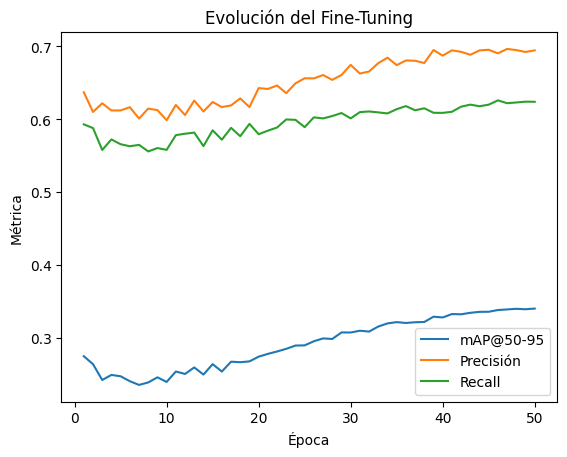

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/drive/MyDrive/yolo_finetune_backup/yolov8m_finetuned_1024/results.csv"
df = pd.read_csv(csv_path)

plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precisión")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.legend(); plt.xlabel("Época"); plt.ylabel("Métrica"); plt.title("Evolución del Fine-Tuning"); plt.show()
